# Credit Card Fraud Detetcion

### Major Project

#### -- Uday Singh

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

In [5]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [7]:
df.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

In [8]:
df.duplicated().sum()

0

the dataset has no missing values or duplicates.

In [9]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


# Features Distribution

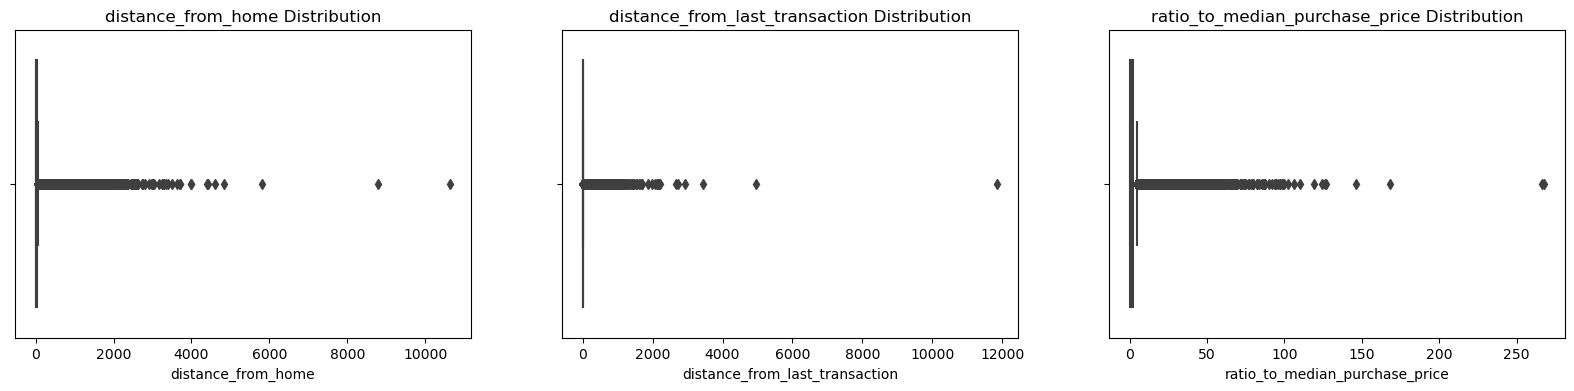

In [10]:
num_features = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
fig,ax = plt.subplots(1,3,figsize=(20,4))
for i,col in enumerate(num_features):
    sns.boxplot(data=df,x=col,ax=ax[i])
    ax[i].set_title(f'{col} Distribution')

In [11]:
df['fraud'].value_counts(normalize=True) * 100

0.0    91.2597
1.0     8.7403
Name: fraud, dtype: float64

In [12]:
df_no_outilers = df.copy()

for col in ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']:
    q1 = df_no_outilers[col].quantile(0.25)
    q3 = df_no_outilers[col].quantile(0.75)
    iqr = q3 - q1 
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df_no_outilers = df_no_outilers[(df_no_outilers[col]>=lower) & (df_no_outilers[col]<=upper)]

In [13]:
df_no_outilers['fraud'].value_counts(normalize=True)*100

0.0    98.748828
1.0     1.251172
Name: fraud, dtype: float64

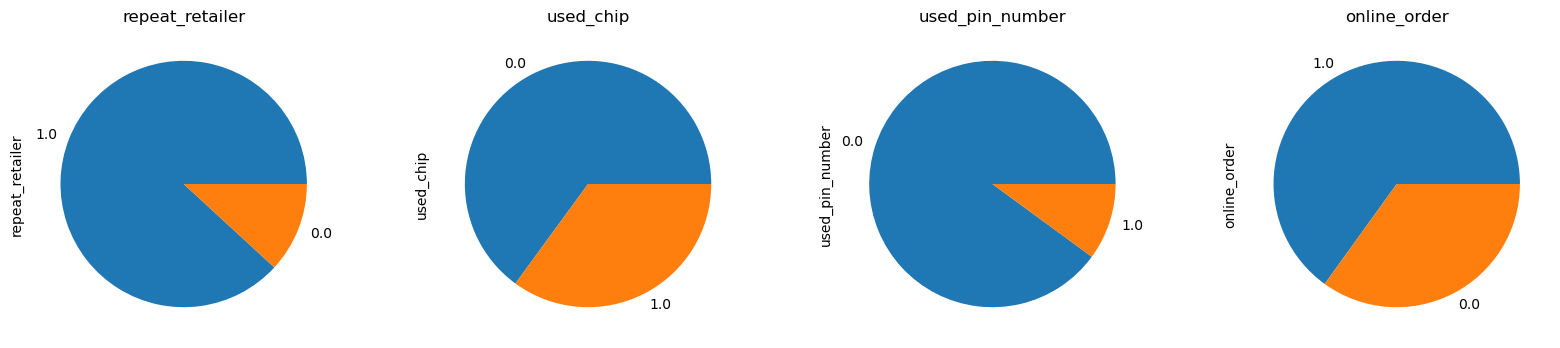

In [14]:
cat_features = ['repeat_retailer', 'used_chip','used_pin_number', 'online_order']
fig,ax = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(cat_features):
    df[col].value_counts().plot(kind='pie',ax=ax[i],title=col)

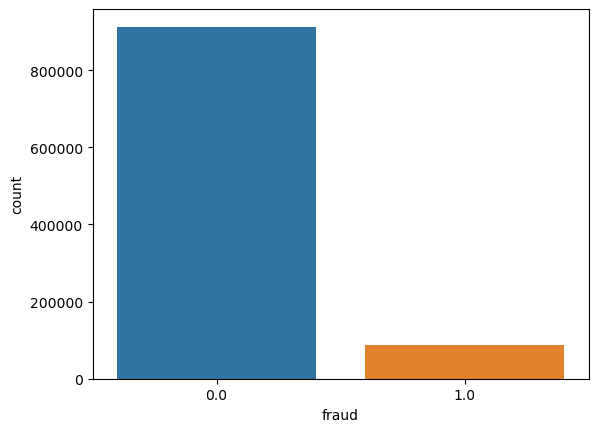

In [15]:
sns.countplot(data=df,x='fraud');

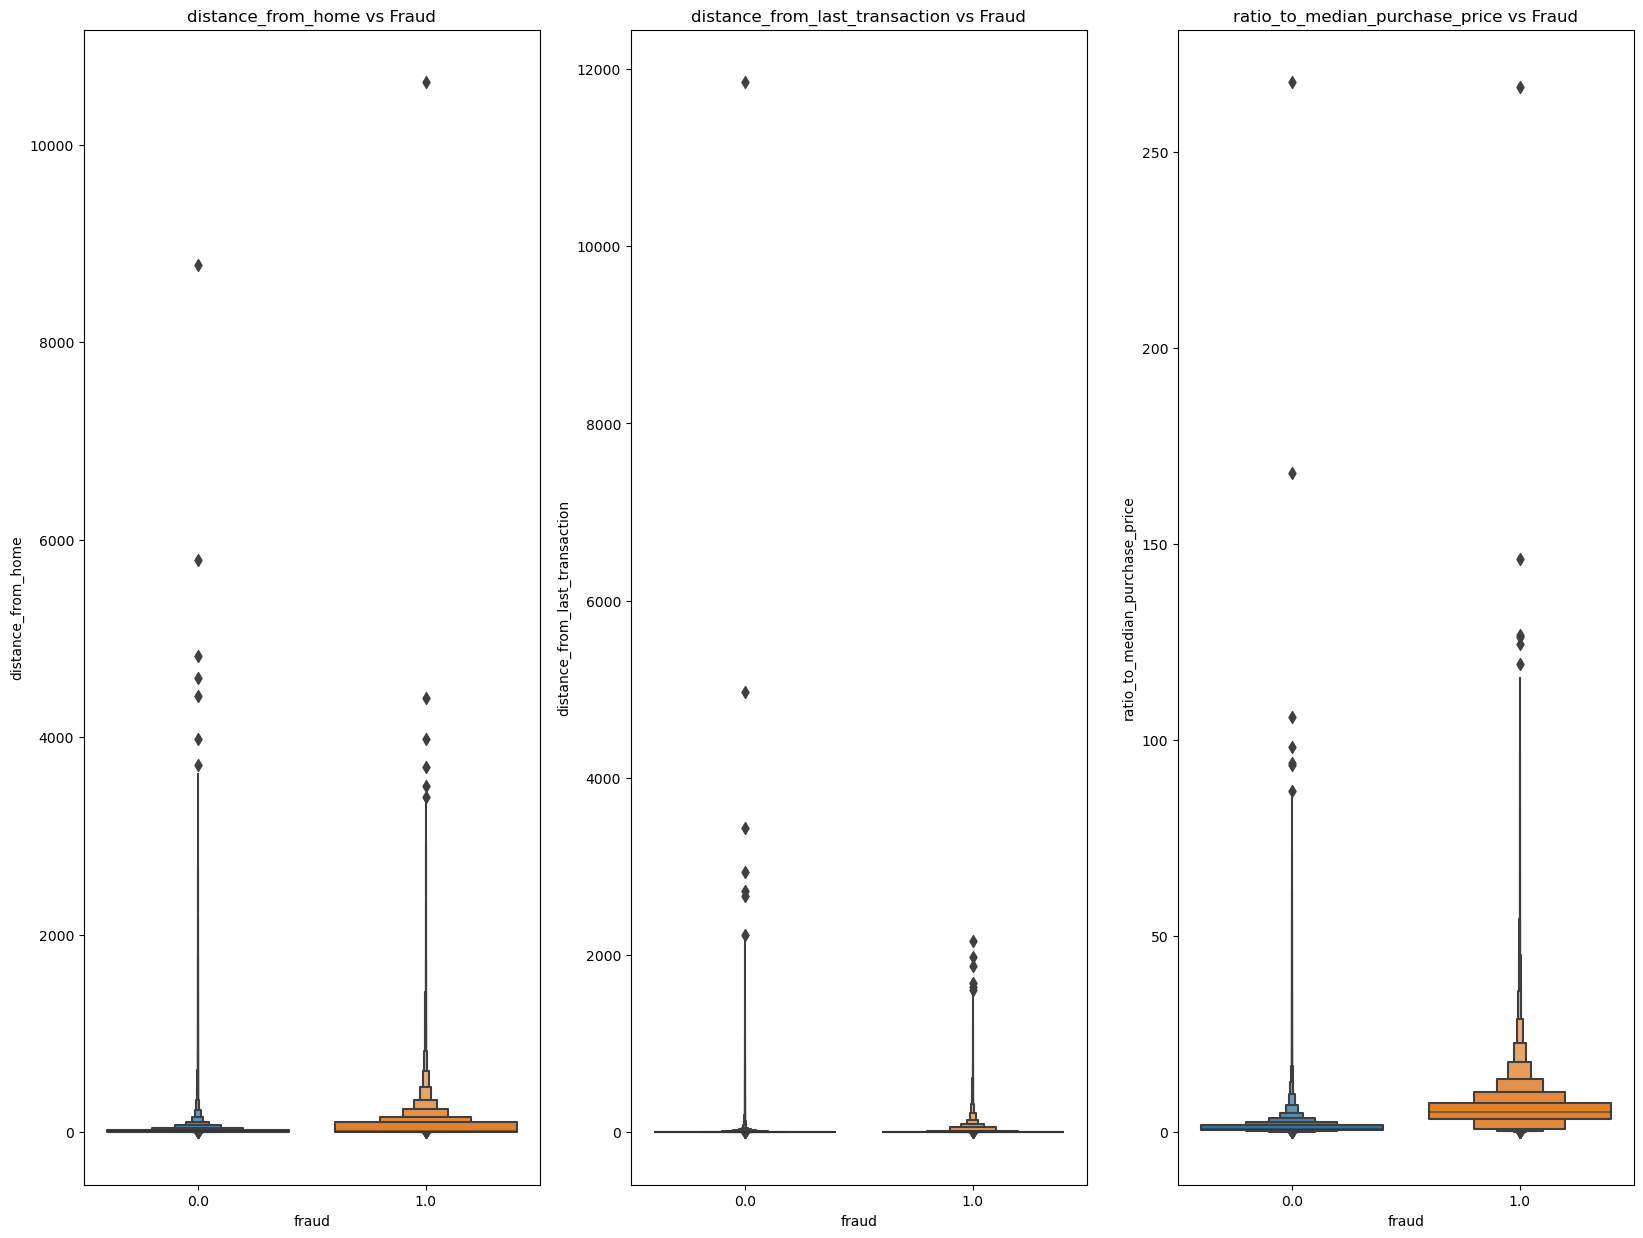

In [16]:
fig,ax = plt.subplots(1,3,figsize=(20,15))
for i,col in enumerate(num_features):
    sns.boxenplot(x=df['fraud'],y=df[col],ax=ax[i])
    ax[i].set_title(f'{col} vs Fraud')

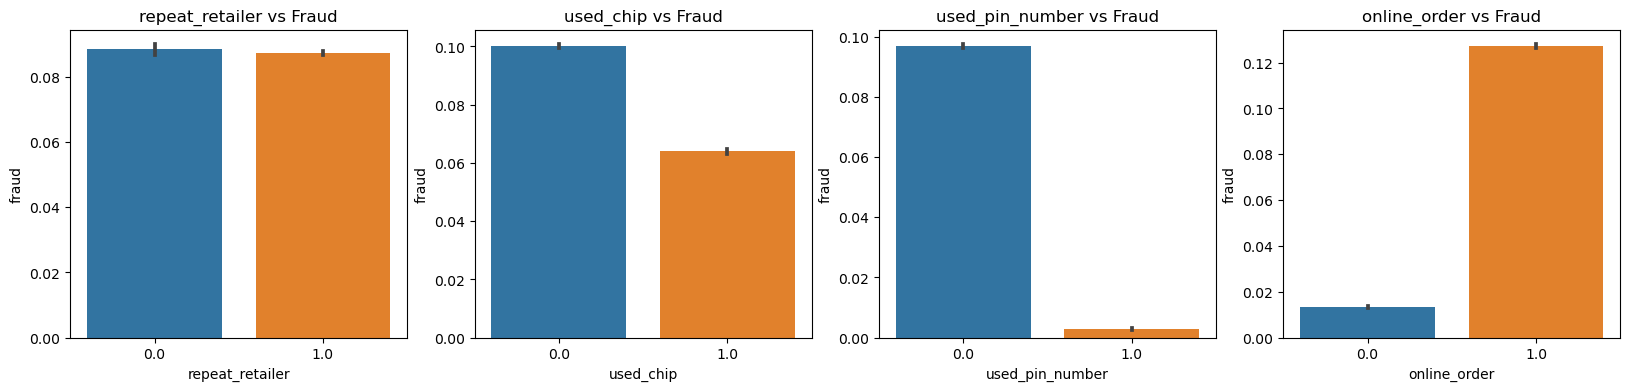

In [17]:
fig,ax = plt.subplots(1,4,figsize=(20,4))
for i,col in enumerate(cat_features):
    sns.barplot(data=df,x=col,y='fraud',ax=ax[i])
    ax[i].set_title(f'{col} vs Fraud')    

Except for repeat_retailer, features have a strong correlation with the target.

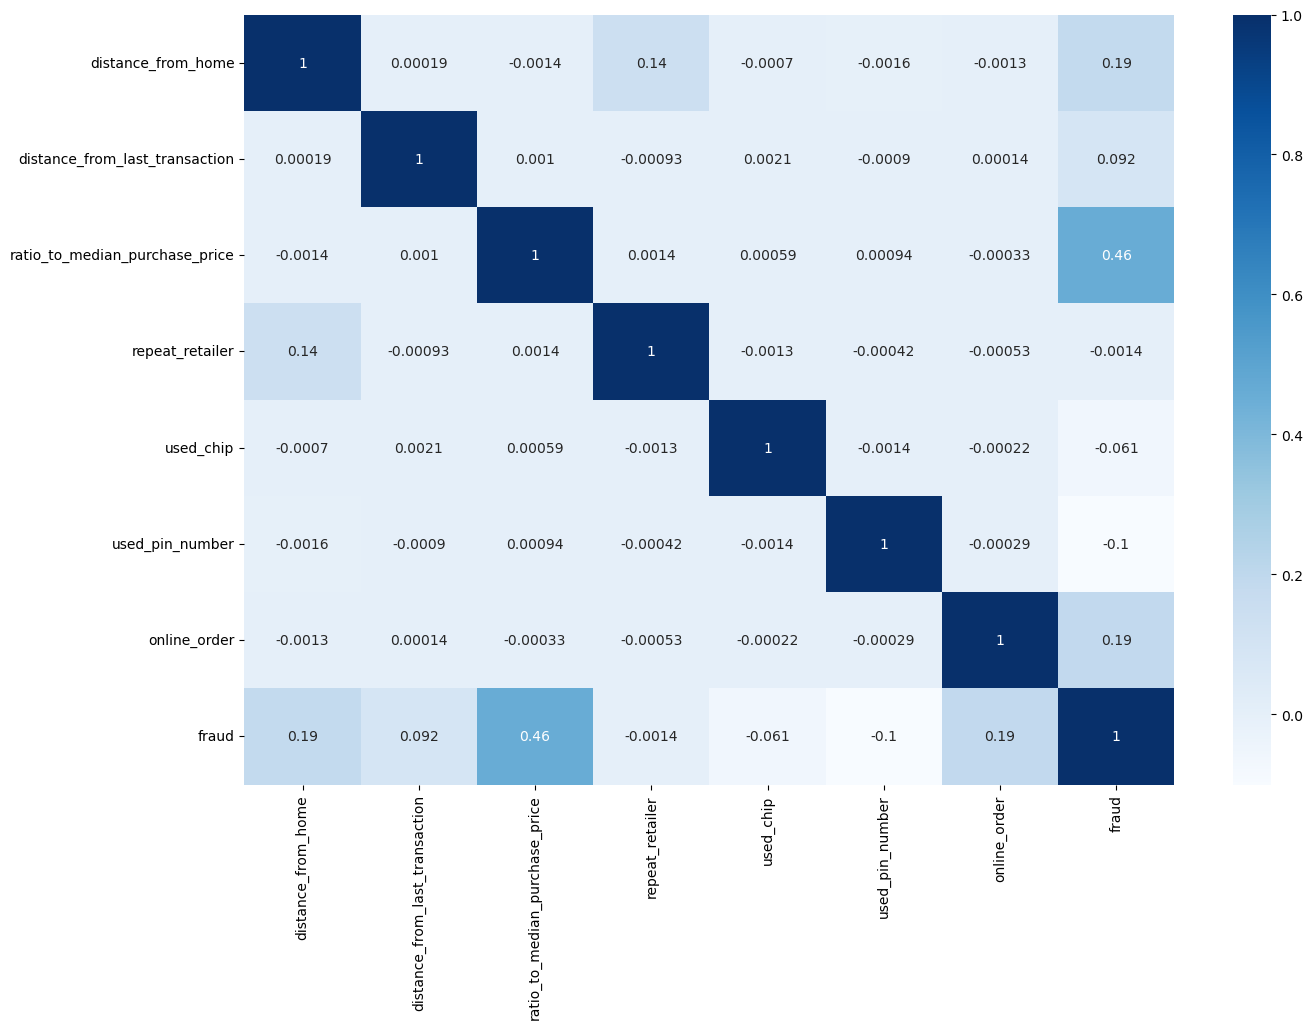

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='Blues',annot=True);

# Model Building

In [19]:
def validate(model,X_train,y_train,score,n):
    
    '''this function is to validate the model across multiple stratified splits'''
    
    splits = StratifiedKFold(n_splits=n)
    validate = cross_val_score(model,X_train,y_train,scoring=score,cv=splits)
    print('Cross Validation Scores: ',validate)
    print('Scores Mean: ',validate.mean())
    print('Scores Standard Deviation: ',validate.std())
    model.fit(X_train,y_train)
    return model

In [20]:
def model_tunning(model,X_train,y_train,param_grid):

    grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='recall')
    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print("Best parameters are: ",best_params)
    print('Mean cross-validated recall of the best_estimator is: ',best_score)
    #print(cv_results)
    return best_estimator

In [21]:
def model_evaluation(model,X_test,y_test,color='Blues',threshold=0.5):
    
    #classification report
    y_proba_test = model.predict_proba(X_test)
    y_pred_test  = (y_proba_test[:,1]>=threshold)
    print(classification_report(y_test,y_pred_test,zero_division=0))
    #confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test,y_pred_test),cmap=color,annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

In [22]:
def precision_recall_trade_off(model,X_test,y_test):

    y_proba = model.predict_proba(X_test)
    precision ,recall ,threshold = precision_recall_curve(y_test,y_proba[:,1])
    p_r_t = pd.DataFrame({'Threshold':threshold,'Precision':precision[:-1],'Recall':recall[:-1]})
    fig = px.line(
        p_r_t,
        x='Recall',
        y='Precision',
        title='Precision-Recall Curve',
        width=700,height=500,
        hover_data=['Threshold']
    )
    fig.show()
    print(p_r_t[ (p_r_t['Recall']==1)].tail(10))

In [23]:
def roc_auc(model,X_test,y_test):

    y_proba = model.predict_proba(X_test)
    fpr ,tpr ,threshold = roc_curve(y_test,y_proba[:,1])
    fp_tp = pd.DataFrame({'Threshold':threshold,'FPR':fpr,'TPR':tpr})
    fig = px.line(
        fp_tp,
        x='FPR',
        y='TPR',
        title='ROC Curve',
        width=700,height=500,
        hover_data=['Threshold']
    )
    fig.show()
    print('Testing ROC-AUC Score: ',roc_auc_score(y_test,y_proba[:,1]))

In [24]:
from sklearn.model_selection import train_test_split , GridSearchCV ,StratifiedKFold , cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , precision_recall_curve , roc_auc_score , roc_curve , classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import VotingClassifier ,RandomForestClassifier ,AdaBoostClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

# Data Splitting and Preprocessing

In [ ]:
features = df.columns.drop(['fraud'])
target = 'fraud'

X = df[features]
y = df[target]

In [ ]:
X_train , X_test ,y_train , y_test = train_test_split(X,y,test_size = 0.2 ,random_state = 42 ,stratify=y)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. Decision Tree Classifier

In [ ]:
dec_tree = validate(DecisionTreeClassifier(random_state=42),X_train,y_train,'recall',5)

In [ ]:
precision_recall_trade_off(dec_tree,X_test,y_test)

In [ ]:
model_evaluation(dec_tree,X_train,y_train,'Blues')

In [ ]:
model_evaluation(dec_tree,X_test,y_test,'Blues')

In [ ]:
roc_auc(dec_tree,X_test,y_test)

In [ ]:
plt.figure(figsize=(80,25))
plot_tree(
          dec_tree,
          feature_names=X.columns,
          class_names=['No Fraud', "Fraud"],
          filled=True,
          rounded=True,
          fontsize=16
);

In [ ]:
feat_imp_dt = pd.Series(dec_tree.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_dt,y=feat_imp_dt.index)
plt.title('Feature Importances');

# 2. XGBoost Classifier

In [ ]:
xgb = validate(XGBClassifier(n_estimators=500 ,random_state=42 ,n_jobs=-1),X_train,y_train,'recall',5)

In [ ]:
precision_recall_trade_off(xgb,X_test,y_test)

In [ ]:
model_evaluation(xgb,X_train,y_train,'Greens',threshold=0.001976)

In [ ]:
model_evaluation(xgb,X_test,y_test,'Greens',threshold=0.001976)

In [ ]:
roc_auc(xgb,X_test,y_test)

# 3. Random Forest Classifier

In [ ]:
rfc = validate(RandomForestClassifier(n_estimators=500 ,n_jobs=-1 ,random_state=42),X_train,y_train,'recall',5)

In [ ]:
precision_recall_trade_off(rfc,X_test,y_test)

In [ ]:
model_evaluation(rfc,X_train,y_train,'Blues',threshold=0.212)

In [ ]:
model_evaluation(rfc,X_test,y_test,'Blues',threshold=0.212)

In [ ]:
roc_auc(rfc,X_test,y_test)

In [ ]:
feat_imp_rf = pd.Series(rfc.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp_rf,y=feat_imp_rf.index)
plt.title('Feature Importances');